# DDPM Model

We will go through the steps to train a DDPM - Denoising Diffusion Probabilistic Model, with the help of a Hugging Face documentation: https://huggingface.co/blog/annotated-diffusion


### Imports:


In [2]:
import sys

sys.path.append("../")
from src.data_preparation import dataloader_service
from src.dataset_acquisition import init_dataset_service
import torch
from torch import nn, einsum
import torchvision.transforms as TF
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
import random

import math
from inspect import isfunction
from functools import partial
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

c:\Users\local_user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set device:


In [3]:
def setup_device():
    device = torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_built() else "cpu"
    )
    return device


device = setup_device()

### Set parameters


In [4]:
def set_paramateres():
    IMAGE_SIZE = 64
    batch_size = 16
    num_epoch = 6

    return IMAGE_SIZE, batch_size, num_epoch


IMAGE_SIZE, batch_size, num_epoch = set_paramateres()

### Load datasets


In [5]:
def load_data():
    flowers_train_loader, flowers_test_loader = (
        dataloader_service.get_dataloader(
            dataset_name="Flowers",
            batch_size=batch_size,
            image_size=IMAGE_SIZE,
            shuffle=True,
            device=device,
            root="../../data/flowers102/",
        )
    )

    celeb_train_loader, celeb_test_loader = (
        dataloader_service.get_dataloader(
            dataset_name="CelebA",
            batch_size=batch_size,
            image_size=IMAGE_SIZE,
            shuffle=True,
            device=device,
            root="../../data/celeba-dataset/",
        )
    )

    return (
        flowers_train_loader,
        flowers_test_loader,
        celeb_train_loader,
        celeb_test_loader,
    )


(
    flowers_train_loader,
    flowers_test_loader,
    celeb_train_loader,
    celeb_test_loader,
) = load_data()

### Examine some images from datasets


In [6]:
reverse_transform = TF.Compose([
    TF.Lambda(lambda t: (t + 1) / 2),
    TF.Lambda(lambda t: t.permute(1, 2, 0)),
    TF.Lambda(lambda t: t * 255.),
    TF.Lambda(lambda t: t.numpy().astype(np.uint8)),
    TF.ToPILImage(),
])

def get_random_image(train_loader):
    train_batch = next(iter(train_loader))
    images, labels = train_batch
    idx = np.random.choice(len(images))
    return images[idx]

def show_random_image(train_loader):
    train_batch = next(iter(train_loader))
    images, labels = train_batch
    idx = np.random.choice(len(images))
    image = reverse_transform(images[idx].squeeze().to("cpu"))
    plt.imshow(image)
    plt.title("Típus: " + str(labels[idx].item()))

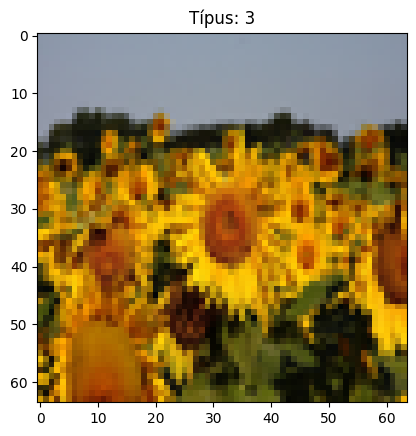

In [7]:
show_random_image(flowers_train_loader)

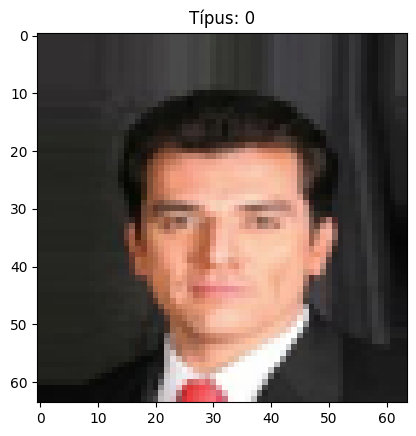

In [8]:
show_random_image(celeb_train_loader)

### Network helpers


In [9]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

### Position embeddings


In [10]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet block


In [11]:
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

### Attention module


In [12]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization


In [13]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net


In [14]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(
            input_channels, init_dim, 1, padding=0
        )  # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        (
                            Downsample(dim_in, dim_out)
                            if not is_last
                            else nn.Conv2d(dim_in, dim_out, 3, padding=1)
                        ),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        (
                            Upsample(dim_out, dim_in)
                            if not is_last
                            else nn.Conv2d(dim_out, dim_in, 3, padding=1)
                        ),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

### Forward diffusion process


In [15]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)


def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2


def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [28]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
x_start = get_random_image(flowers_train_loader).unsqueeze(0).to("cpu")
x_start.shape

In [ ]:
reverse_transform(x_start.squeeze())

In [16]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

#### Test forward diffusion


In [17]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image


In [ ]:
t = torch.tensor([40])
plt.imshow(get_noisy_image(x_start, t))

#### Visualize forward diffusion


In [18]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


In [ ]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

#### Define loss function


In [19]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss


### Sampling


In [62]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


### Training


In [21]:
def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr



In [ ]:
from torch.optim import Adam

model = Unet(
    dim=IMAGE_SIZE,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(loader):
    epochs = num_epoch
    steps = len(loader) * epochs
    progress = 0

    for epoch in range(epochs):
        for step, batch in enumerate(loader):
            optimizer.zero_grad()

            batch, label = batch

            batch_size = batch.shape[0]
            batch = batch.to(device)

            # Algorithm 1 line 3: sample t uniformally for every example in the batch
            t = torch.randint(0, timesteps, (batch_size,), device=device).long()

            loss = p_losses(model, batch, t, loss_type="huber")

            loss.backward()
            optimizer.step()

            progress = progress + 1
            print(f"Progress: {progress}/{steps} ({progress / steps * 100:.2f}%, Loss: {loss})", end="\r")
    return model


#### Train on flowers


In [ ]:
flower_model = train(flowers_train_loader)


### Train on CelebA

#### Setup


In [ ]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

model = Unet(
    dim=IMAGE_SIZE,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

#### Train


In [ ]:
celeba_model = train(celeb_train_loader)

### Generate images


In [ ]:
# sample 64 images
samples_flowers = sample(flower_model, image_size=IMAGE_SIZE, batch_size=64, channels=3)
# samples_celeba = sample(celeba_model, image_size=IMAGE_SIZE, batch_size=64, channels=3)

In [33]:
def get_img_from_sample(sample):
    return reverse_transform(torch.from_numpy(sample).squeeze())

In [ ]:
# show a random one
rand_idxs = [random.randint(0, 63) for _ in range(5)]
images = [get_img_from_sample(samples_flowers[-1][random_index]) for random_index in rand_idxs]
plot(images)

In [ ]:
# show a random one
rand_idxs = [random.randint(0, 63) for _ in range(10)]
images = [get_img_from_sample(samples_celeba[-1][random_index]) for random_index in rand_idxs]
print(rand_idxs)
plot(images)

### Generate gif

In [ ]:
import matplotlib.animation as animation

random_index = 60

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(get_img_from_sample(samples_celeba[i][random_index]), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()


In [ ]:
torch.save(celeba_model.state_dict(), "celeba_model.pth")
torch.save(flower_model.state_dict(), "model_flowers.pth")

In [ ]:
new_model = Unet(
    dim=IMAGE_SIZE,
    dim_mults=(1, 2, 4,)
)
model.to(device)

new_model.load_state_dict(torch.load("celeba_model.pth", weights_only=False))

In [ ]:
samples_new = sample(new_model, image_size=IMAGE_SIZE, batch_size=4, channels=3)


In [ ]:
rand_idxs = [0,1,2,3]
images = [get_img_from_sample(samples_new[-1][random_index]) for random_index in rand_idxs]
plot(images)

In [94]:
model_flowers_ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4)
)

model_path_ddpm = "../models/flowers/flowers_model_best.pth"
model_flowers_ddpm.load_state_dict(torch.load(model_path_ddpm, map_location="cpu"))

C:\Users\local_user\AppData\Local\Temp\ipykernel_17668\126560391.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_flowers_ddpm.load_state_dict(torch.load(model_path

<All keys matched successfully>

In [29]:
# Példa a generálásra
batch_size = 16
image_size = 64  # Generált képek mérete
channels = 3  # Színes képek (RGB)
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
# Képek generálása


generated_images = sample(model_flowers_ddpm, image_size, batch_size=batch_size, channels=channels)


sampling loop time step: 100%|██████████| 300/300 [09:26<00:00,  1.89s/it]


In [37]:
import os

save_dir = "generated_images"
os.makedirs(save_dir, exist_ok=True)

# Csak a végső generált képek (utolsó időlépés)
final_images = generated_images[-1]  # Numpy array

for i, img in enumerate(final_images):
    # Használjuk a get_img_from_sample függvényt
    processed_img = get_img_from_sample(img)  # Ez egy PIL.Image.Image típusú objektum lesz

    # Mentés közvetlenül a PIL.Image mentési metódusával
    processed_img.save(os.path.join(save_dir, f"image_{i + 1}.png"))

print(f"Images saved to {save_dir}")


Images saved to generated_images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1867169..1.0987183].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0953915..1.2156255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1071216..1.1900598].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1656722..1.157144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3206176..1.2646995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1896327..1.1309776].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0783882

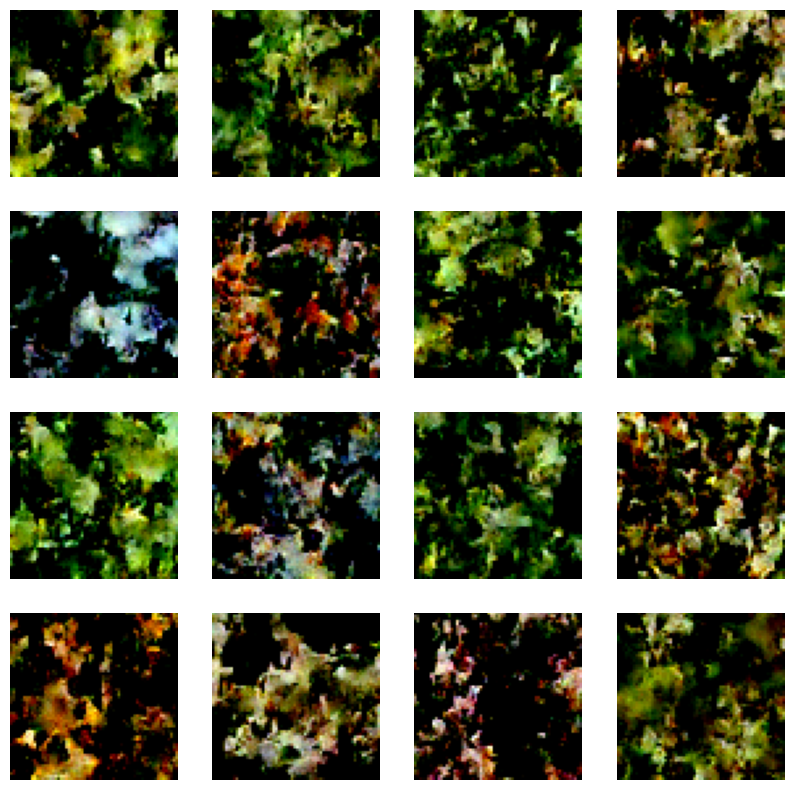

In [38]:
import matplotlib.pyplot as plt

# Véletlenszerűen kiválasztott képek kirajzolása
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(np.transpose(final_images[i], (1, 2, 0)))
    plt.axis("off")
plt.show()


In [ ]:
rand_idxs = [random.randint(0, 63) for _ in range(5)]
images = [get_img_from_sample(samples_flowers[-1][random_index]) for random_index in rand_idxs]
plot(images)

In [39]:
model_flowers_ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4)
)

model_path_ddpm = "../models/flowers/2/flowers_model_best.pth"
model_flowers_ddpm.load_state_dict(torch.load(model_path_ddpm, map_location="cpu"))

C:\Users\local_user\AppData\Local\Temp\ipykernel_17668\4259625825.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_flowers_ddpm.load_state_dict(torch.load(model_pat

<All keys matched successfully>

In [56]:
model_celeba_ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4)
)

model_path_ddpm = "../models/celeba/2/celeba_model_best.pth"
model_celeba_ddpm.load_state_dict(torch.load(model_path_ddpm, map_location="cpu"))

C:\Users\local_user\AppData\Local\Temp\ipykernel_17668\2931027758.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_celeba_ddpm.load_state_dict(torch.load(model_path

<All keys matched successfully>

In [ ]:
import os
from datetime import datetime


timesteps = 320
betas = linear_beta_schedule(timesteps=timesteps)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]])
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

# Mappa létrehozása, ha nem létezik
output_dir = "results/generated_flower_ddpm_images"
os.makedirs(output_dir, exist_ok=True)

# Paraméterek és generálás
num_images = 30
samples = sample(model_flowers_ddpm, image_size=64, batch_size=num_images, channels=3)

def get_img_from_sample(sample):
    """Egy generált minta átalakítása képpé."""
    return reverse_transform(torch.from_numpy(sample).squeeze())

fig, axes = plt.subplots(1, num_images, figsize=(15, 30))

for i in range(num_images):
    # Az utolsó lépésből vesszük ki a megfelelő képet
    sample_image = samples[-1][i]  # Itt az egyedi képet vesszük ki a listából
    generated_image = get_img_from_sample(sample_image)  # Átalakítás kép formátumra
    
    # Fájlnév az aktuális időbélyeggel
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
    output_path = os.path.join(output_dir, f"generated_image_{timestamp}.png")
    
    # Kép mentése
    generated_image.save(output_path)
    print(f"A kép elmentve: {output_path}")

    # Egy példa kép megjelenítése
    axes[i].imshow(generated_image)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

Képek betöltése...
Képek megjelenítése...


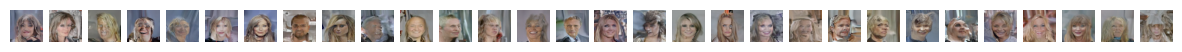

Inception Score: 2.3724905372 ± 0.3698033076


In [ ]:
import os
import torch
import numpy as np
from torchvision import transforms, models
from PIL import Image
from scipy.stats import entropy


def load_images_from_folder(folder, image_size=(64, 64)):
    """
    Betölti az összes képet egy mappából, és átméretezi azokat az adott méretre.
    
    Args:
        folder (str): A mappa elérési útja.
        image_size (tuple): Az új képméret (299, 299 az Inception-hez).
    
    Returns:
        list of torch.Tensor: Az előfeldolgozott képek listája.
        list of PIL.Image: Az eredeti képek listája vizualizációhoz.
    """
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizálás
    ])
    images = []
    original_images = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        try:
            with Image.open(filepath).convert("RGB") as img:
                original_images.append(img.copy())  # Mentés megjelenítéshez
                images.append(transform(img))
        except Exception as e:
            print(f"Nem sikerült betölteni a(z) {filepath} képet: {e}")
    return torch.stack(images), original_images


def calculate_inception_score(images, inception_model, splits=10):
    """
    Számítsa ki az Inception Score-t (IS) az adott képek alapján.
    
    Args:
        images (torch.Tensor): A képek tensorja (N, 3, 64, 64).
        inception_model (torch.nn.Module): Az előre betanított Inception modell.
        splits (int): Az IS kiszámításának szakaszai.
    
    Returns:
        float: Az IS átlaga.
        float: Az IS szórása.
    """
    inception_model.eval()
    with torch.no_grad():
        preds = []
        batch_size = 32
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size]
            preds.append(inception_model(batch).softmax(dim=1).cpu().numpy())
        preds = np.concatenate(preds, axis=0)

    N = preds.shape[0]
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = [entropy(pyx, py) for pyx in part]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

def show_images(images, num_images=10):
    """
    Megjeleníti a betöltött képeket.
    
    Args:
        images (list of PIL.Image): A betöltött képek listája.
        num_images (int): Hány képet jelenítsen meg.
    """
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# Beállítások
folder_path = "results/generated_ddpm_celeb_images"  # Cseréld ki a saját mappád elérési útjára
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Képek betöltése
# Képek betöltése
print("Képek betöltése...")
processed_images, original_images = load_images_from_folder(folder_path)

# Képek megjelenítése
print("Képek megjelenítése...")
show_images(original_images, num_images=30)



In [113]:
from torchvision.models import inception_v3
from scipy.stats import entropy

# Betöltött és előfeldolgozott képek
print("Inception modell betöltése és előkészítése...")
inception_model = inception_v3(pretrained=True)
inception_model.transform_input = False
inception_model.Conv2d_1a_3x3.conv = torch.nn.Conv2d(
    in_channels=3,
    out_channels=32,
    kernel_size=(3, 3),
    stride=(1, 1),
    padding=(1, 1),
    bias=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processed_images = processed_images.to(device)
inception_model = inception_model.to(device)

# IS számítása
print("Inception Score számítása...")
is_mean, is_std = calculate_inception_score(processed_images, inception_model, splits=10)
print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")

Inception modell betöltése és előkészítése...
Inception Score számítása...
Inception Score: 2.86 ± 0.17


Fordított Diffúziós Lépés látványosan

Diffúziós folyamat vizualizálása...


sampling loop time step: 100%|██████████| 300/300 [02:10<00:00,  2.30it/s]


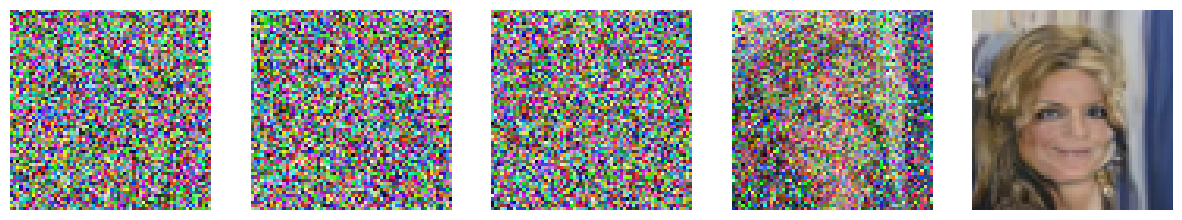

In [114]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import random


@torch.no_grad()
def visualize_diffusion_process(model, timesteps=300, steps_to_plot=5, image_size=64, channels=3):
    """
    Generál egy képet a fordított diffúziós folyamattal, és 5 részre osztva vizualizálja az időlépéseket.
    
    Args:
        model (nn.Module): A betöltött CelebA modell.
        timesteps (int): A fordított diffúziós folyamat lépéseinek száma (pl. 300).
        steps_to_plot (int): Hány egyenlő időintervallumban jelenítse meg az állapotokat (pl. 5).
        image_size (int): A generált képek mérete (pl. 128x128).
        channels (int): A képek csatornáinak száma (pl. 3 RGB esetén).
    """
    device = next(model.parameters()).device
    batch_size = 1  # Csak egy képet generálunk
    img = torch.randn((batch_size, channels, image_size, image_size), device=device)
    
    # Időlépések, amelyeket meg kell jeleníteni
    plot_steps = torch.linspace(0, timesteps - 1, steps_to_plot, dtype=torch.long).tolist()
    
    imgs_to_plot = []
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        t = torch.full((batch_size,), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t, t_index=i)
        
        # Ha az aktuális időlépés megfelel a vizualizáció lépéseinek
        if i in plot_steps:
            imgs_to_plot.append(img.clone().cpu())

    # Átalakítás képpé és vizualizálás
    imgs_to_plot = [reverse_transform(img.squeeze()) for img in imgs_to_plot]
    plot_images(imgs_to_plot)


def plot_images(images):
    """
    Képeket rajzol ki egymás mellé.
    
    Args:
        images (list): A generált képek listája.
    """
    plt.figure(figsize=(15, 5))
    num_images = len(images)
    for idx, img in enumerate(images):
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()


# CelebA modell használata
print("Diffúziós folyamat vizualizálása...")
visualize_diffusion_process(
    model=model_celeba_ddpm,  
    timesteps=300,
    steps_to_plot=5,
    image_size=64,
    channels=3,
)


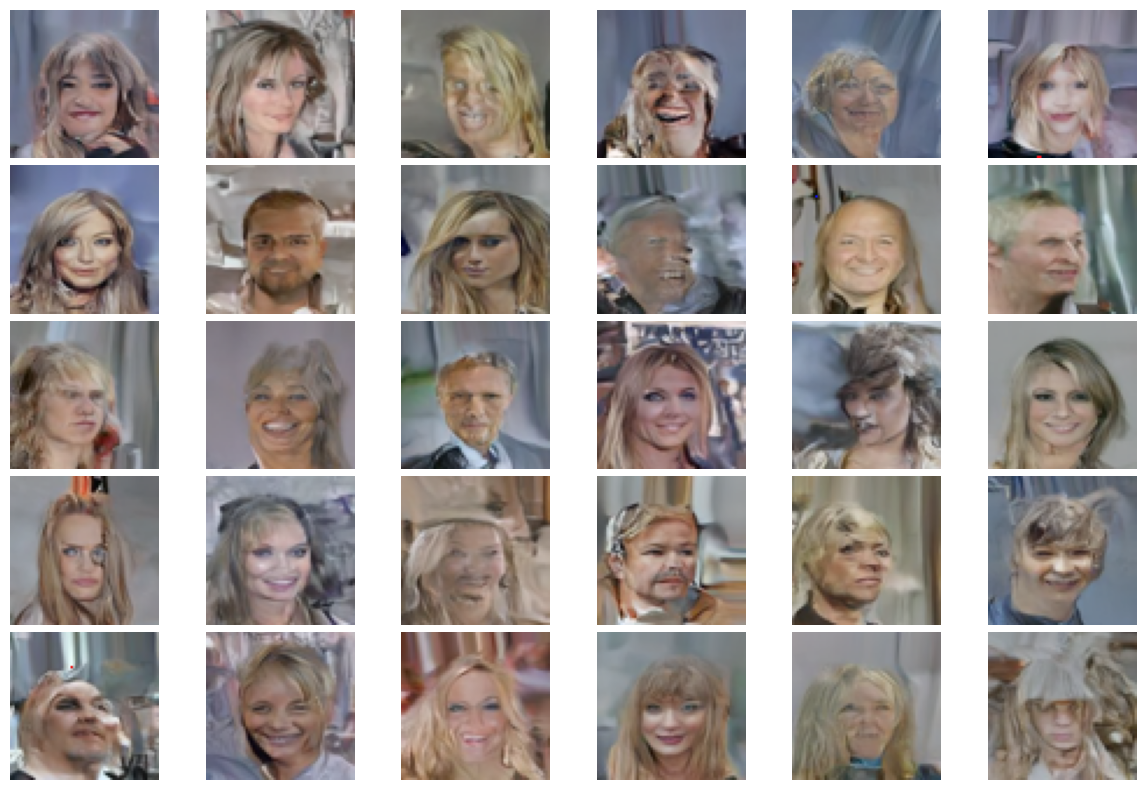

In [123]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def plot_images_from_folder(folder_path, max_images=30):
    # Listázzuk a mappa tartalmát (csak a képfájlokat)
    image_files = [
        os.path.join(folder_path, file)
        for file in os.listdir(folder_path)
        if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif"))
    ]
    
    # Limitáljuk az olvasandó képek számát
    image_files = image_files[:max_images]
    
    # Képek beolvasása
    images = [Image.open(file) for file in image_files]
    
    # Beállítjuk a plot méretét (5 sor, 6 oszlop)
    fig, axes = plt.subplots(5, 6, figsize=(15, 10))
    axes = axes.flatten()  # Könnyebb iterálni a tengelyeken
    
    # Minimalizáljuk a képek közötti helyet
    fig.subplots_adjust(wspace=0.06, hspace=0.05)
    
    # Képek megjelenítése
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis("off")  # Kikapcsoljuk a tengelyeket
    
    # Ha kevesebb kép van, mint 30, az üres subplotokat kikapcsoljuk
    for ax in axes[len(images):]:
        ax.axis("off")
    
    # Megjelenítjük a gridet
    plt.show()

# Mappa megadása (cseréld ki a saját mappádra)
folder_path = "results/generated_ddpm_celeb_images"  # Add meg a mappa elérési útját
plot_images_from_folder(folder_path)

